<a href="https://colab.research.google.com/github/hugobbi/generating-rare-concepts/blob/main/dl_cv_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies

In [ ]:
!pip install diffusers transformers accelerate scipy safetensors

## Imports

In [ ]:
import torch
from torchvision import transforms
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Utils

In [32]:
def get_inputs(prompt, batch_size=1, num_inference_steps=20):
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
  prompts = [prompt for _ in range(batch_size)]

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_to_tensor(image):
    image_tensor = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # normalize between -1 and 1
    ])(image)

    return image_tensor.unsqueeze(0).to("cuda", dtype=torch.float16) # unsqueeze(0) adds new dimension to tensor at index 0

def map_to_zero_one(tensor):
    tensor = (tensor.clamp(-1, 1) + 1) / 2.0 # map tensor from (-1, 1) to (0, 1)
    return tensor

## Importing Stable Diffusion 2.1 from HuggingFace and CLIP vision model

In [ ]:
# Paper:
# SeedSelect employs Stable Diffusion v2.1 with a guidance scale of 7.5 and 7 denoising steps
# using EulerDiscreteScheduler (Karras et al. 2022)
model_id = "stabilityai/stable-diffusion-2-1-base" # use "stabilityai/stable-diffusion-2-1-base" (512x512) if not enough ram other is (768x768)

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

pipe.schedueler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

# CLIP vision model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Using SD model

  0%|          | 0/20 [00:00<?, ?it/s]

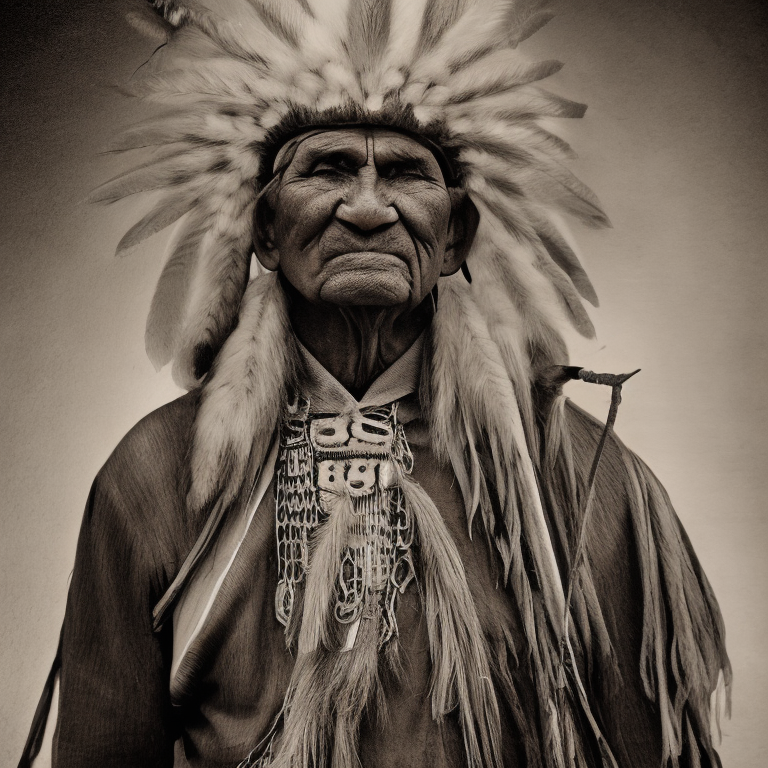

In [19]:
NUM_INFERENCE_STEPS = 20 # 7
GUIDANCE_SCALE = 7.5

generator = torch.Generator("cuda").manual_seed(0)
prompt = "portrait photo of an old warrior chief"
image = pipe(prompt, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator).images[0]

image

  0%|          | 0/20 [00:00<?, ?it/s]

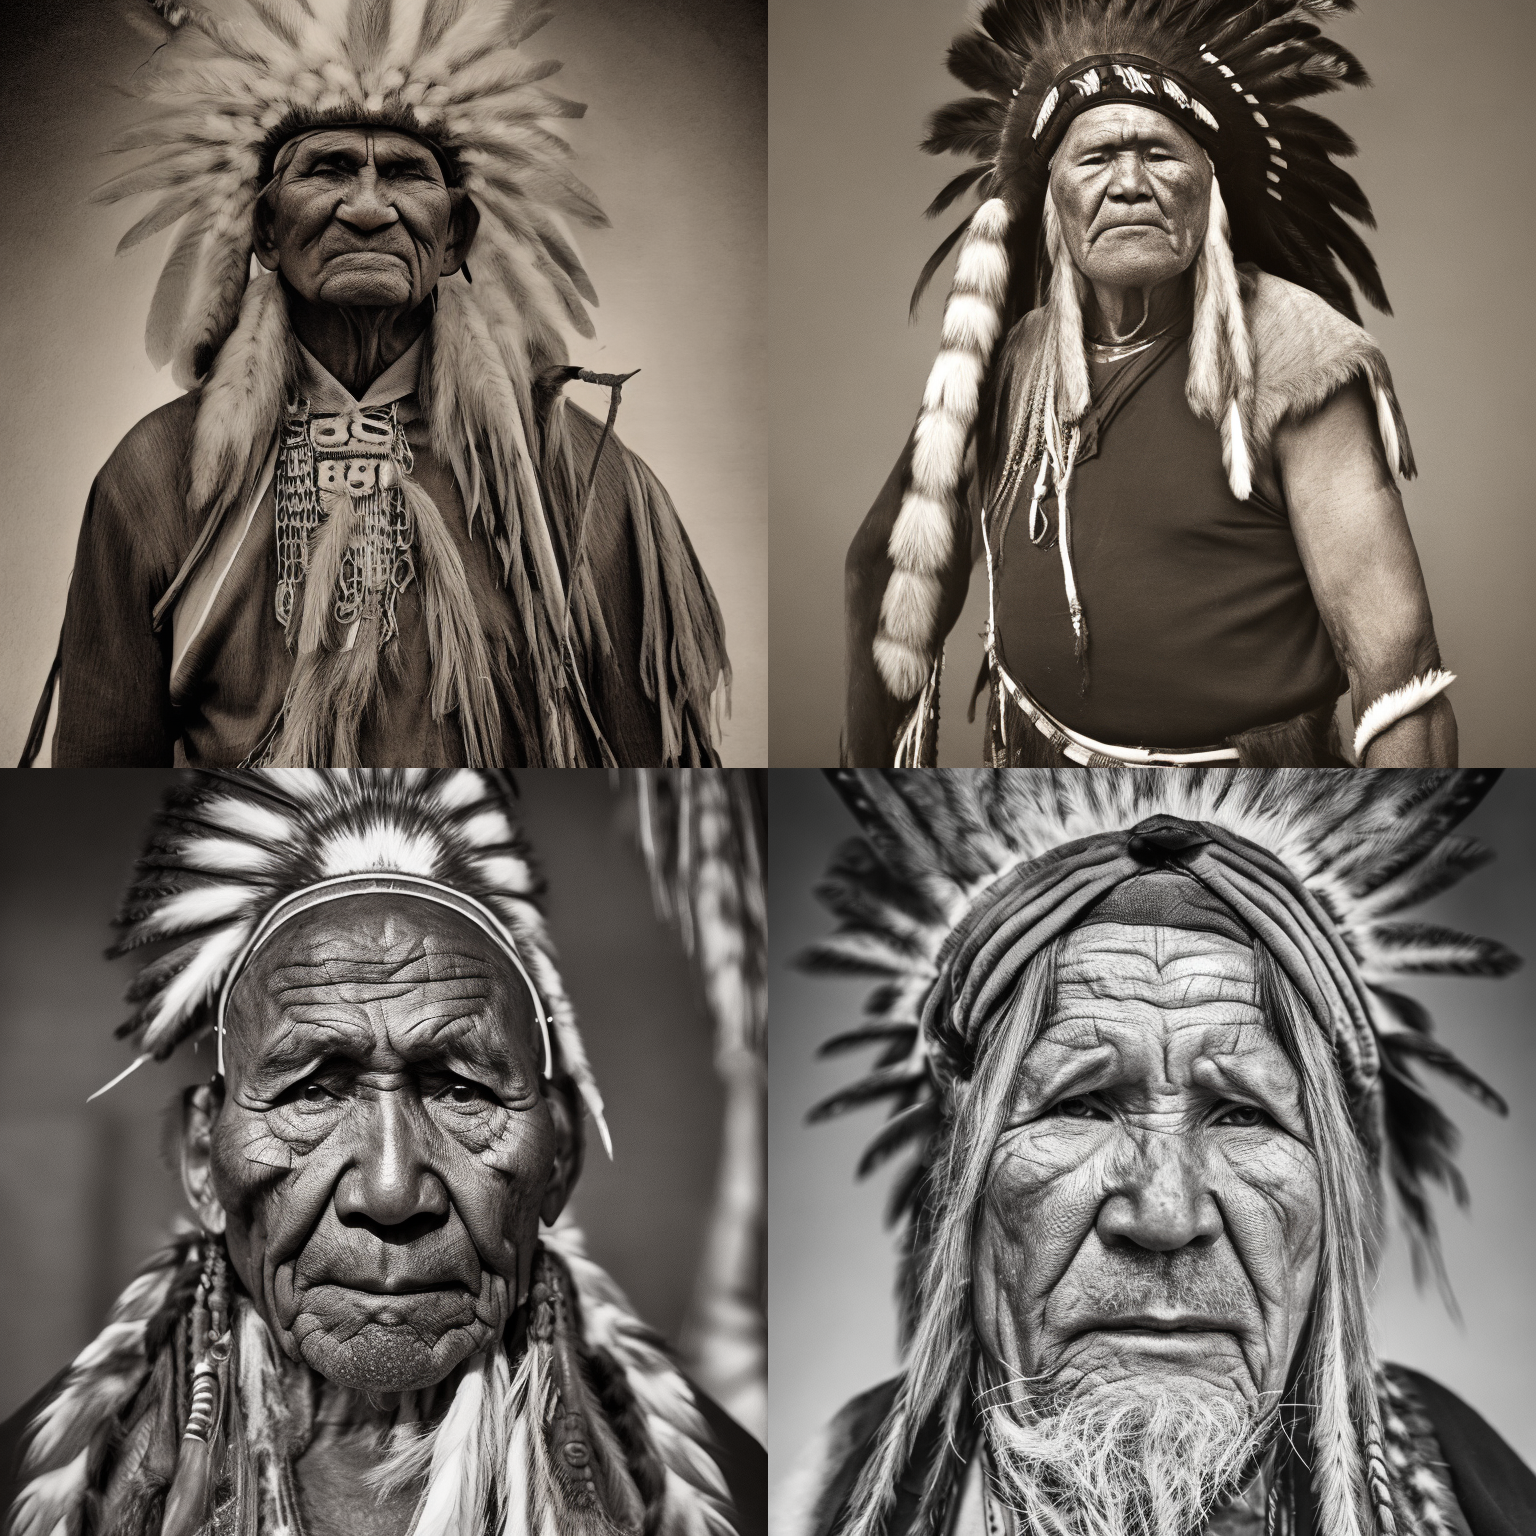

In [ ]:
images = pipe(**get_inputs(prompt=prompt, batch_size=4)).images
image_grid(images)

## VAE

In [ ]:
# VAE

def encode_image_vae(pipe, image):
    vae = pipe.vae
    image_tensor = image_to_tensor(image)
    with torch.no_grad():
        image_latent = vae.encode(image_tensor).latent_dist.sample().detach() # samples from latent distribution
        image_latent *= 0.18215

    return image_latent

def decode_vae(pipe, image_latent):
    vae = pipe.vae
    with torch.no_grad():
        image_latent /= 0.18215
        image = vae.decode(image_latent).sample

    image = map_to_zero_one(image)

    return image

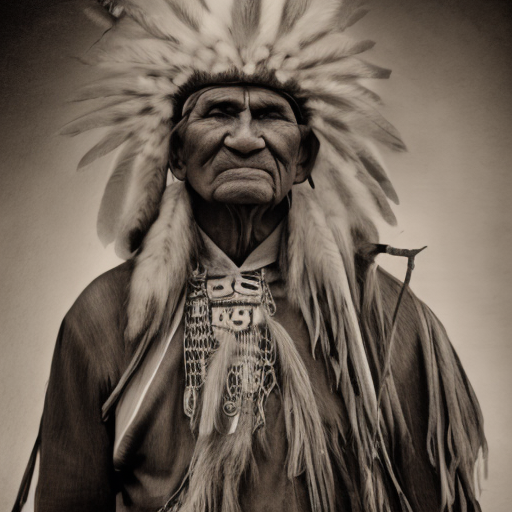

In [ ]:
img_latent = encode_image_vae(pipe, image)
img = decode_vae(pipe, img_latent)
img_pil = transforms.ToPILImage()(img.squeeze())
img_pil

## CLIP Vision

In [ ]:
# CLIP

def encode_image_clip(clip_model, clip_processor, image):
    inputs = clip_processor(images=image, return_tensors="pt").to("cuda")
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=inputs["pixel_values"])

    return image_embeddings

In [ ]:
image_embeddings = encode_image_clip(clip_model, clip_processor, image)
image_embeddings.shape

torch.Size([1, 768])

## Using random gaussian as initial latent

  0%|          | 0/20 [00:00<?, ?it/s]

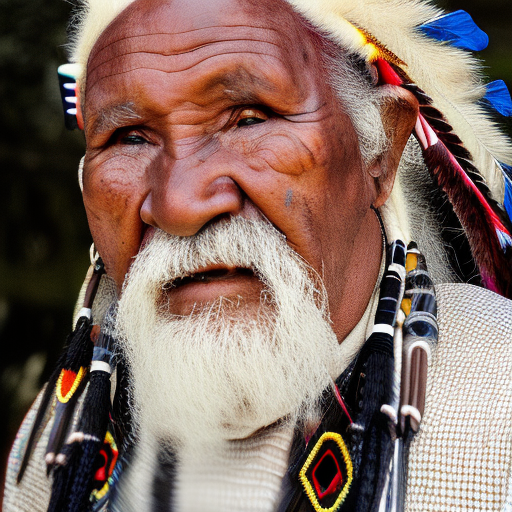

In [31]:
# Generating and using custom gaussian noise tensor

# Matching the UNet input size
batch_size = 1
channels = pipe.unet.config.in_channels
height = 512 // 8  # latent space size (image size divided by 8)
width = 512 // 8

generator = torch.Generator("cuda").manual_seed(0)
custom_latents = torch.randn((batch_size, channels, height, width), device="cuda", dtype=torch.float16, generator=generator)
output_custom_latents  = pipe(prompt, latents=custom_latents, num_inference_steps=NUM_INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator)

image_custom_latents = output_custom_latents.images[0]
image_custom_latents

## TODO

- generate images [x]
- access vae [x]
- access initial distribution [x]
- access clip encoder [x]
- compute semantic loss []
- compute visual loss []
- optimize new latent []